In [1]:
import time 
import copy
import glob 
import random

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

In [20]:
train_normal = glob.glob("chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("chest_xray/test/PNEUMONIA/*")

train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

print (type(test_labels))

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels,
                                                                        stratify=train_labels)

5216 5216
624 624
<class 'list'>


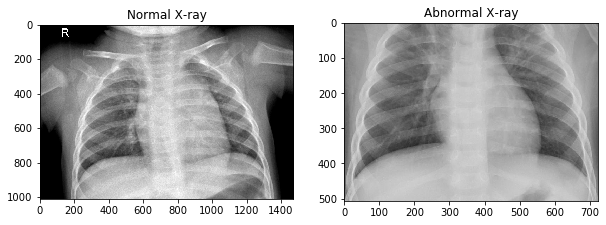

In [37]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)    
    
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")
    
show_random_images()

In [28]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[index]
        label = torch.tensor([label])
        
        return image, label

class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1) 
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)        
        x = self.backbone.relu(x)       
        x = self.backbone.maxpool(x)  
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)        
        x = self.backbone.layer3(x)        
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        
        x = x.view(x.size(0), 512)
        x = self.fc(x)
        
        return x

image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [29]:
#Start training

pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)


dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/elmer007/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [31]:
model.cpu()

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [40]:
def train_model(model, criterion, optimizer, num_epochs, device="cpu"):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), 
                                            leave=False, 
                                            total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss // ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects // ((i+1) * batch_sizes[phase])   
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")
                    
            epoch_loss = running_loss // dataset_sizes[phase]
            epoch_acc = running_corrects.double() // dataset_sizes[phase]
            
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    
    print(f"training took {time_elapsed} seconds")
    
    model.load_state_dict(best_model_wts)
    
    return model

In [41]:
model = train_model(model, criterion, optimizer, num_epochs)

[train]: 1 / 5 | loss : 0.0 | acc : 0
[train]: 1 / 5 | loss : 0.0 | acc : 0


KeyboardInterrupt: 

In [ ]:
test_paths = glob.glob("../data/test/NORMAL/*") + glob.glob("../data/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("../data/test/NORMAL/*")) + [1] * len(glob.glob("../data/test/PNEUMONIA/*"))

len(test_paths), len(test_labels)

test_dataset = XrayDataset(test_paths, test_labels, test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predictions = model(tensors.cuda())
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions)
        
        y_true.append(labels)
y_pred.shape, y_true.shape,

y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

y_pred.shape, y_true.shape

from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
